# Stock Prediction with Transfer Learning

In this notebook, we explore stock price prediction using data sourced from Yahoo Finance. To leverage the latest advancements in machine learning, we employ transfer learning algorithms, with a particular focus on Chronos, a groundbreaking model introduced by Amazon in 2024, which is based on Large Language Models (LLMs).

Chronos stands out due to its remarkable scalability and versatility. Unlike traditional models that require extensive training, Chronos (https://github.com/amazon-science/chronos-forecasting) has been pre-trained on vast and diverse datasets, making it adaptable to a wide range of financial time series tasks without requiring additional training. However, fine-tuning the model with domain-specific data can further improve performance.

This notebook demonstrates how to harness the power of Chronos for stock prediction, applying state-of-the-art techniques with minimal setup, and offers insights into the transformative impact of LLMs on financial forecasting.

In [1]:
#We import necessary libraries
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchmetrics
from utils.functions import *

import torch
from chronos import ChronosPipeline

We imported the data from yahoo finance

In [2]:
#We downloaded the data using yahoo finance
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 1, 1)# dt.datetime.now()

# Energy Stocks
energy_stocks = ['TTE'] 
stock_data = {stock: get_data(stock, start_date, end_date) for stock in energy_stocks}

df_stock_data = pd.DataFrame.from_dict(stock_data)

[*********************100%***********************]  1 of 1 completed


We divide the database into train, validation and test

In [3]:
split_idx_train = int(len(df_stock_data) * 0.6)
split_idx_val = int(len(df_stock_data) * 0.2)


train_df = df_stock_data[:split_idx_train + split_idx_val]
test_df = df_stock_data[split_idx_train + split_idx_val:]

print('date range train: {} - {} '.format(train_df.index[0],train_df.index[-1]))
print('date range test: {} - {} '.format(test_df.index[0],test_df.index[-1]))

date range train: 2020-01-02 00:00:00 - 2023-10-25 00:00:00 
date range test: 2023-10-26 00:00:00 - 2024-10-10 00:00:00 


In [4]:
name_target ='TTE' #

set_train_chronos = pd.Series(train_df[name_target])


In [5]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
    )

In [6]:
#prediction_length = 64  #Max len recommended by Chronos
prediction_length = len(test_df)

predict_test = pipeline.predict(
        context= torch.tensor(set_train_chronos),
        prediction_length = prediction_length,
        num_samples= prediction_length,
        limit_prediction_length=False
        )

low, median, high = np.quantile(predict_test[0].numpy(),[0.1, 0.5, 0.9], axis=0)

/tmp/ipykernel_258448/2170094452.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context= torch.tensor(set_train_chronos),
/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/chronos/chronos.py:507: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [7]:
mape_metric = torchmetrics.MeanAbsolutePercentageError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)  

metrics_final = {
            'rmse_test': rmse_metric(torch.tensor(np.hstack(test_df[:prediction_length].values)),
                                      torch.tensor(median)).item(),
            'mape_test': mape_metric(torch.tensor(np.hstack(test_df[:prediction_length].values)),
                                      torch.tensor(median)).item(),
            }
ds = pd.Series(metrics_final)
ds.round(3)

rmse_test    2.950
mape_test    0.037
dtype: float64

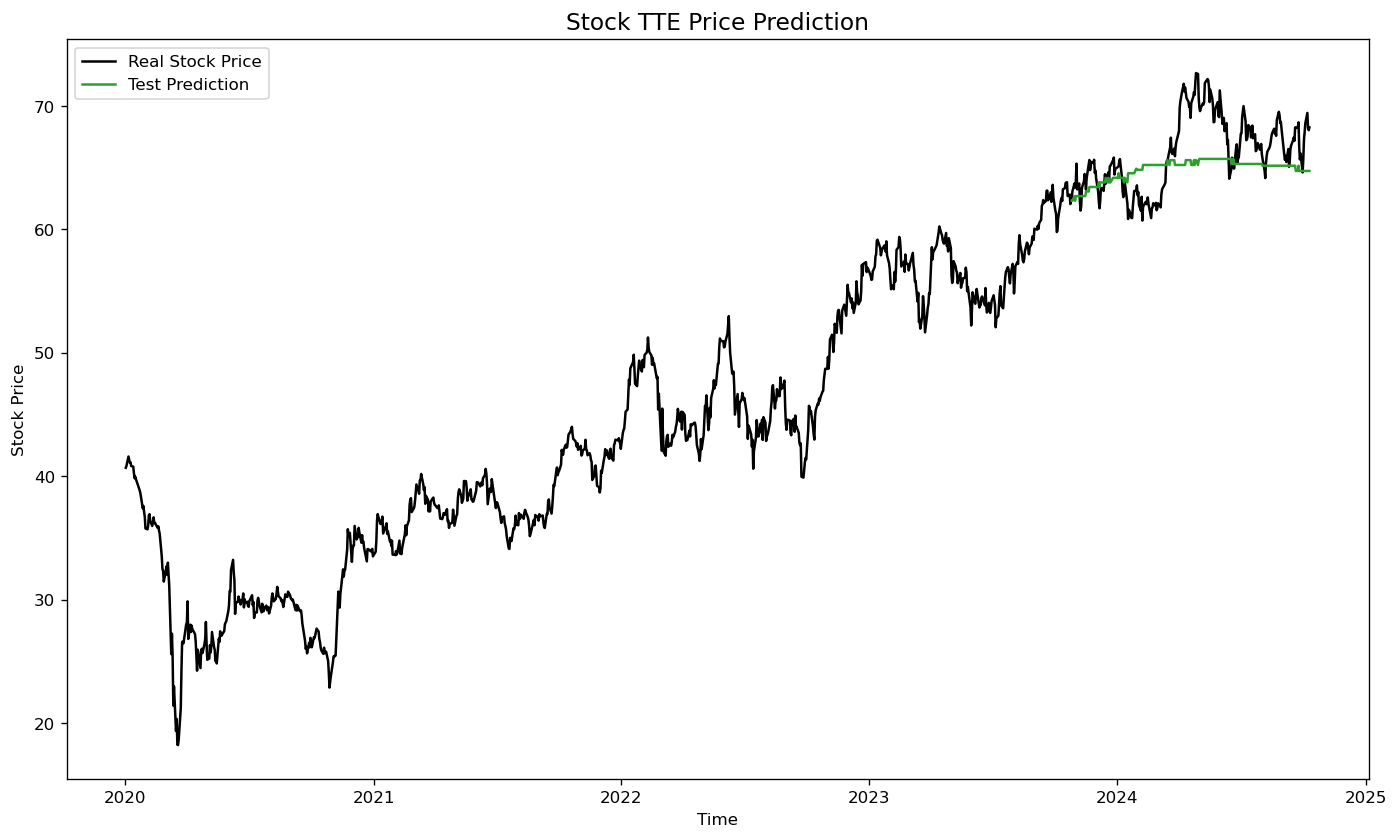

In [8]:
plt.figure(figsize=(14, 8), dpi=120)    

index_real_data = train_df.index.to_list() + test_df.index.to_list()[:prediction_length]
plt.plot(df_stock_data.loc[index_real_data], label='Real Stock Price', color='k')
plt.plot(test_df.index[:prediction_length], median, color='C2', label='Test Prediction')

plt.title('Stock ' +name_target+' Price Prediction', size=14)
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.legend()
plt.show()
